In [12]:
%load_ext autoreload
%autoreload 2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from scipy.interpolate import CubicSpline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
extracted_eyes = get_eyes('sample_3.jpg')
cx,cy = get_center(extracted_eyes)
cx,cy 

(208, 158)

#### measurements 

- sample_2.jpg , MRD1 = 4mm 
- sample_3.jpg , MRD1 = 4mm
- sample_4.jpg , MRD1 = 1mm
- sample_5.jpg , MRD1 = 3.5mm 

#### px to mm
- 1 px = 0.264583 mm

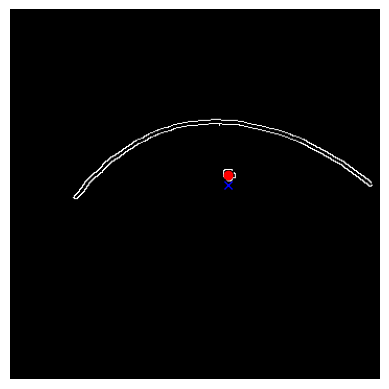

In [14]:
edges = cv2.Canny(extracted_eyes,450,600)
max_y = edges.shape[0]
plt.imshow(edges,cmap='gray')
plt.axis('off')
# mark cx,cy on the image
plt.plot(cx,cy,'ro')
plt.plot(cx,cy+10,'bx')
plt.show()

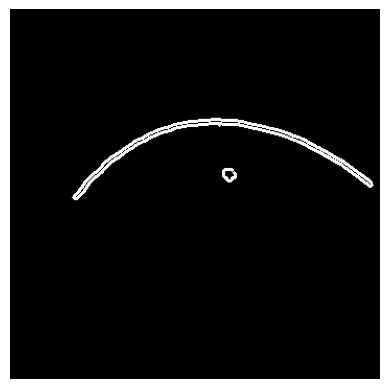

In [15]:

kernel = make_circular_kernel((3,3),1)
edges = cv2.dilate(edges,kernel,iterations=1) 
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.show()



In [16]:
# draw contours 
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



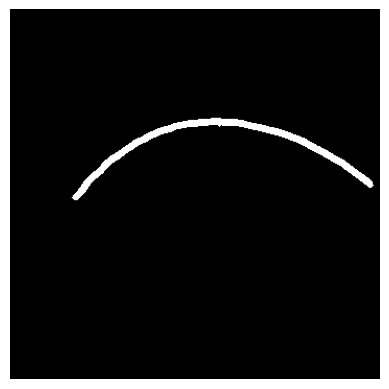

In [17]:
# get the largest contour
largest_contour = max(contours, key=cv2.contourArea)
mask = np.zeros_like(extracted_eyes)
cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), -1)

plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.show()



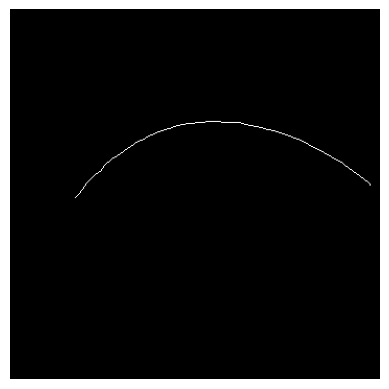

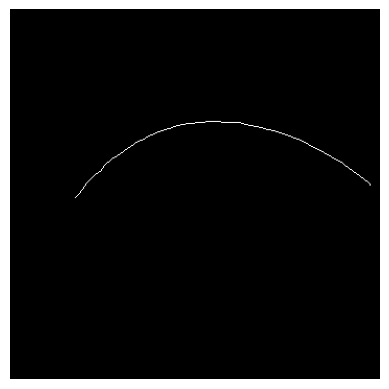

In [18]:

#skeletonize the mask
from skimage.morphology import skeletonize

skeleton = skeletonize(mask)
plt.imshow(skeleton,cmap='gray')
plt.axis('off')
plt.show()
skeleton=skeleton.astype(np.uint8)
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
mask = np.zeros_like(extracted_eyes)
cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), -1)

plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.show()

In [19]:
# apply cubic spline on the largest contour 
x = largest_contour[:,0,0]
y = largest_contour[:,0,1]
points = np.array([x,y]).T
# modify the y to be max_y - y
points[:,1] = max_y - points[:,1]

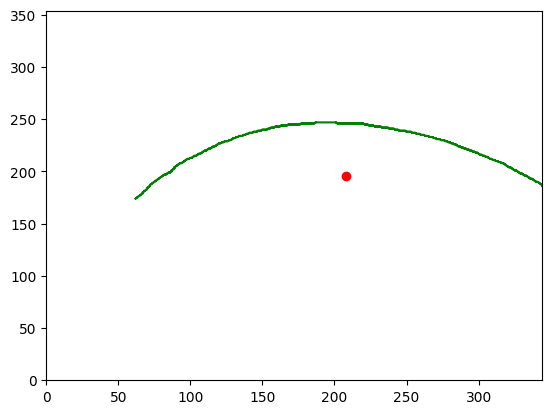

In [20]:
# plot x,y 
# invert the y axis
# plt.plot(x, y)
plt.scatter(cx,max_y-cy,color='red')
plt.plot(points[:,0],points[:,1],color='green')
# show the image from 0 to max_y
plt.ylim(0,max_y)
plt.xlim(0,points[:,0].max())
plt.show()



In [21]:
for i in np.where(abs(points[:,0]-cx)<=5)[0]:
    print(i,x[i],y[i])
    dist = round((points[:,1][i] - cy),2)
    print(np.sqrt(dist) , dist*0.264)

Cubic polynomial: -95.95278946969945x^3 + -237.53099104026506x^2 + 3719.8773157241485x + 6724.963581584941
(1000,)
(1000,)


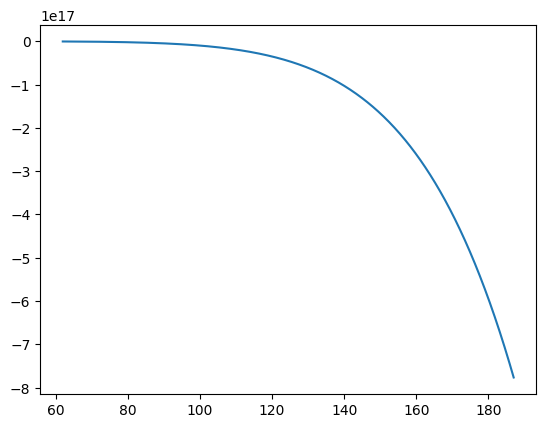

In [32]:
# sort x , y 
x= points[:,0]
y= points[:,1]
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

any_dict = dict() # x -> y last value

for i in range(len(x)):
    any_dict[x[i]] = y[i]
x= list(any_dict.keys())
y= list(any_dict.values())

# sample the first and last points together with 5 random samples in between and the maximum y too 
randomchoice=np.random.randint(1,len(x)-1,3)
# random_x=x[randomchoice]
# random x is the x values of the random choice
random_x = [x[i] for i in randomchoice]
x_forhighesty= x[np.argmax(y)]
x = [x[0],x[-1]]
x.extend(random_x)
x.append(x_forhighesty)
# random_y=y[randomchoice]
random_y = [y[i] for i in randomchoice] 
y = [y[0],y[-1]]
y.extend(random_y)
y.append(y[np.argmax(y)])

# spline = CubicSpline(list(any_dict.keys()), list(any_dict.values())) 
# x = list(any_dict.keys())
# x_new = np.linspace(x[0], x[-1], 1000)
# y_new = spline(x_new)
# print(x.shape)
# print(y.shape)
# convert x and y to lists 
coefficients = least_squares_cubic(x, y)

# Print the cubic polynomial in user-friendly format
print(f"Cubic polynomial: {coefficients[0]}x^3 + {coefficients[1]}x^2 + {coefficients[2]}x + {coefficients[3]}")

# plot the points and the cubic polynomial
x_new = np.linspace(x[0], x[-1], 1000)
y_new = np.polyval(coefficients, x_new)
print(x_new.shape)
print(y_new.shape)
plt.plot(x_new, y_new)
# plt.scatter(x_new, y_new)



# plt.plot(x_new,y_new)

# plt.show()


Cubic polynomial: 1.5833333333333612x^3 + -4.666666666666705x^2 + 6.000000000000009x + -2.3333333333333313
(1000,)
(1000,)


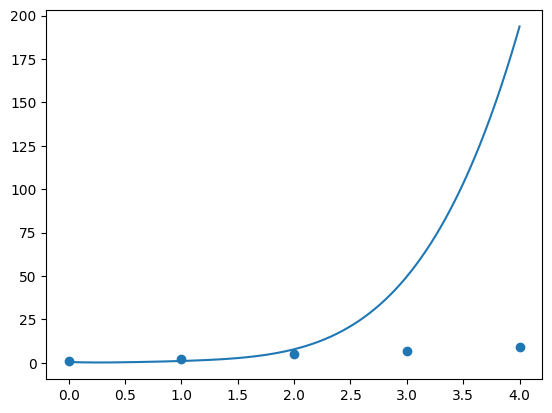

In [125]:
import numpy as np

def least_squares_cubic(x, y):
  """
  Find the coefficients of a cubic polynomial that interpolates to the given points
  using least squares.

  Args:
      x: A list of x-coordinates.
      y: A list of y-coordinates corresponding to the x-coordinates.

  Returns:
      A list of coefficients [a, b, c, d] for the cubic polynomial ax^3 + bx^2 + cx + d.
  """

  # Design matrix with ones on the diagonal, x, x^2, and x^3
  A = np.vander(x, increasing=True).T

  # Solve the linear system using least squares
  coefficients, _, _, _ = np.linalg.lstsq(A, y, rcond=None)

  return coefficients.tolist()

# Sample data points
x = [0, 1, 2, 3,4]
y = [1, 2, 5, 7,9]
# convert x, y to numpy arrays
x = np.array(x)
y = np.array(y)

# Find the coefficients of the cubic polynomial
coefficients = least_squares_cubic(x, y)

# Print the cubic polynomial in user-friendly format
print(f"Cubic polynomial: {coefficients[0]}x^3 + {coefficients[1]}x^2 + {coefficients[2]}x + {coefficients[3]}")

# plot the points and the cubic polynomial
plt.scatter(x, y)
x_new = np.linspace(x[0], x[-1], 1000)
y_new = np.polyval(coefficients, x_new)
print(x_new.shape)  
print(y_new.shape)
plt.plot(x_new, y_new)


In [98]:
# what's next ? 
# measure our own mrd1 from the picture and compare with the given one (image caption in wp)
# mark (draw) the upper lid contour and get the maximum point (highest y)
# get the distance betweeen the pupil and the highest point of the upper lid contour
# convert px to mm :) 


# after success , 
# GET THE GUI DONE ! like the paper 